In [1]:
import imageio.v3 as iio
import torch
import os
import cv2
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.transforms import ToTensor

from s3dg import S3D

s3d_model = S3D('s3d_dict.npy', 512)
s3d_model.load_state_dict(torch.load('s3d_howto100m.pth'))

s3d_model = s3d_model.eval()
s3d_model = s3d_model.to('cuda')

In [6]:
video_dir = Path("alignment_sample")
text = [filepath.split(".mp4")[0].replace("_", " ") for filepath in os.listdir(video_dir)]

def video_to_tensor(video_path):
    cap = iio.imread(video_path)
    frames = []
    for frame in cap:
        frame = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_AREA)
        frame = torch.tensor(frame, dtype=torch.float32) / 255.0
        frames.append(frame)
    if len(frames) % 2 == 1:
        frames = frames[:-1]
    
    frames = torch.stack(frames) 
    return frames.permute(3, 0, 1, 2).unsqueeze(0)

def compute_v2t_similarity_matrix(video, text):
    with torch.no_grad():
        text_output = s3d_model.text_module([text])["text_embedding"]
        text_emb = text_output[0]
        video_emb = s3d_model(video)["video_embedding"]
    return F.cosine_similarity(text_emb, video_emb, dim=-1).item()

vt = video_to_tensor(video_dir/"leveling_off_from_banking_left.mp4") # [B, C, T, H, W]
vt.shape


torch.Size([1, 3, 216, 256, 256])

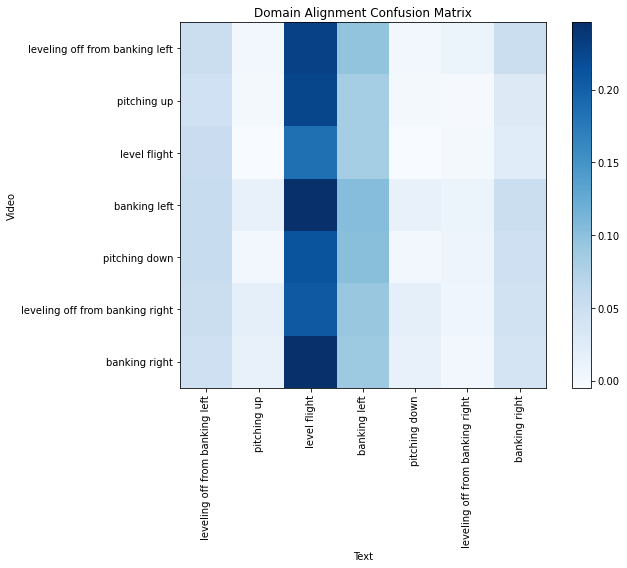

In [7]:
sim = []

for file_path in os.listdir(video_dir):
    vt = video_to_tensor(video_dir / file_path)
    vt = vt.to('cuda')
    for t in text:
        sim.append(compute_v2t_similarity_matrix(vt, t))

sim_matrix = np.array(sim).reshape(len(text), len(text))
plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Domain Alignment Confusion Matrix')
plt.xlabel('Text')
plt.ylabel('Video')
plt.xticks(np.arange(len(text)), text, rotation=90)
plt.yticks(np.arange(len(text)), text)
plt.tight_layout()
plt.show()

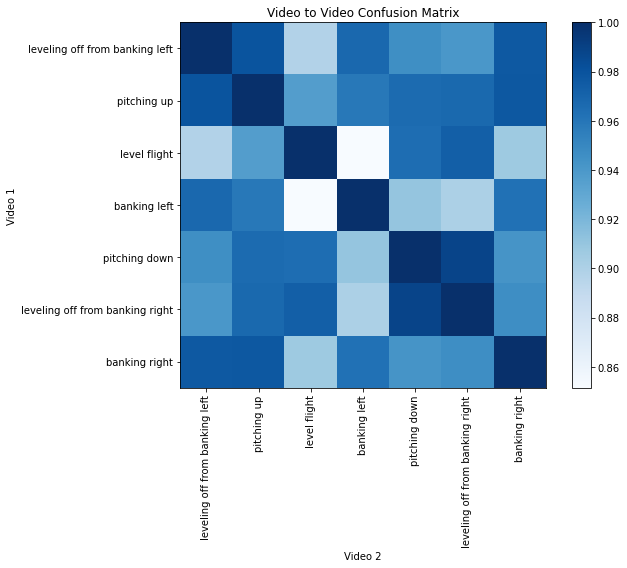

In [8]:
sim = []
vts = []

for fp in os.listdir(video_dir):
    vt = video_to_tensor(video_dir / fp)
    vt = vt.to('cuda')
    with torch.no_grad():
        vt_emb = s3d_model(vt)["video_embedding"]
    vts.append(vt_emb)

for v1 in vts:
    for v2 in vts:
        sim.append(F.cosine_similarity(v1, v2, dim=-1).item())

sim_matrix = np.array(sim).reshape(len(text), len(text))
plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Video to Video Confusion Matrix')
plt.xlabel('Video 2')
plt.ylabel('Video 1')
plt.xticks(np.arange(len(text)), text, rotation=90)
plt.yticks(np.arange(len(text)), text)
plt.tight_layout()
plt.show()

plotting based on cosine similarity


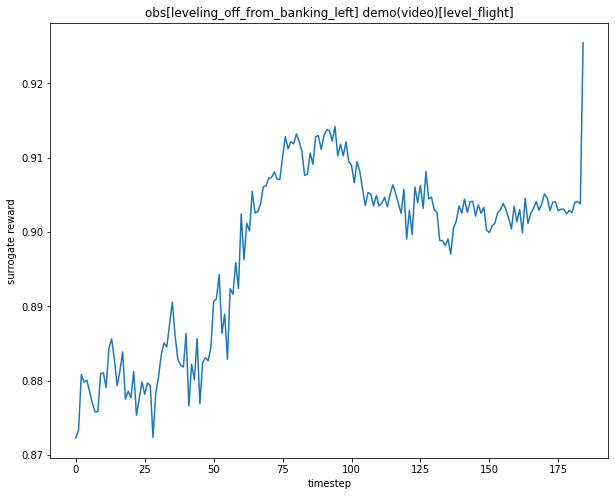

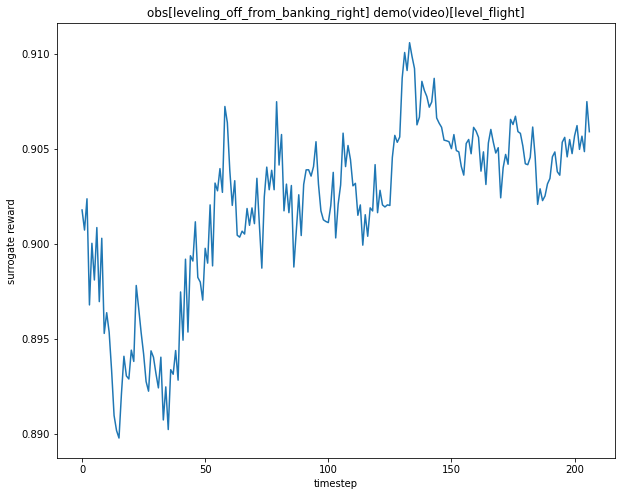

plotting based on dot-product similarity


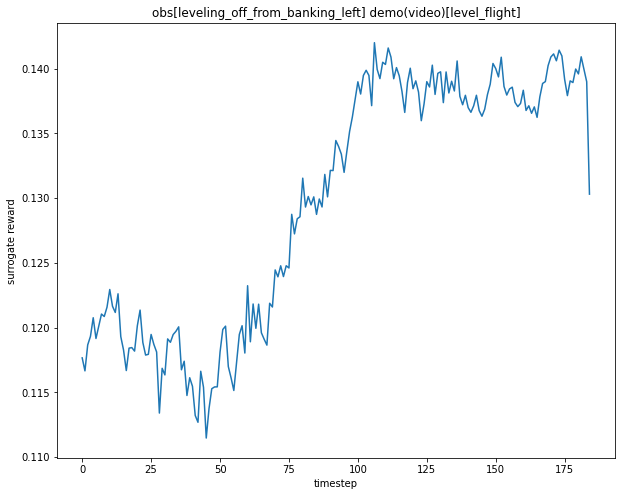

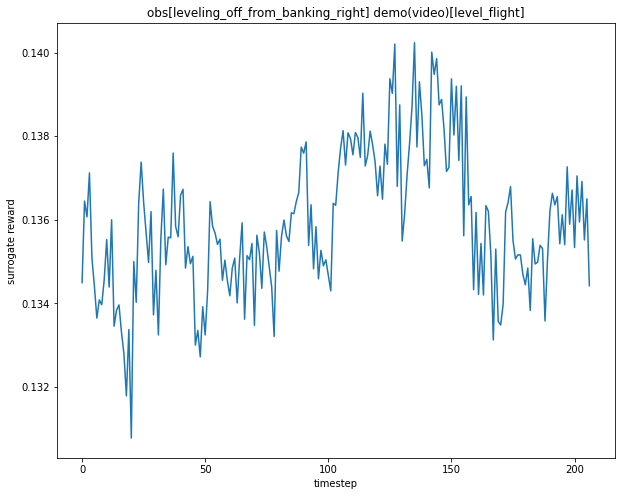

In [9]:
def plot_v2v_windowed_cosine_similarity(demo_path, obs_path):
    demo_name = demo_path.stem
    obs_name = obs_path.stem
    
    demo = video_to_tensor(demo_path).to('cuda')  # [b, c, n_frames, w, h]
    obs = video_to_tensor(obs_path)

    window_size = 32

    surrogate_reward = []

    with torch.no_grad():
        demo_emb = s3d_model(demo)["video_embedding"].to('cpu')  # [1, 512]

        for start_idx in range(obs.shape[2]-window_size+1):
            window = obs[:, :, start_idx:start_idx+window_size, :, :].to('cuda')
            window_emb = s3d_model(window)["video_embedding"].to('cpu')  # [1, 512]
            
            surrogate_reward.append(F.cosine_similarity(demo_emb, window_emb, dim=-1).item())

    plt.figure(figsize=(10, 8))
    plt.plot(surrogate_reward)
    plt.xlabel('timestep')
    plt.ylabel('surrogate reward')
    plt.title(f'obs[{obs_name}] demo(video)[{demo_name}]')
    plt.show()

    return np.array(surrogate_reward)


def plot_v2v_windowed_dotproduct_similarity(demo_path, obs_path):
    demo_name = demo_path.stem
    obs_name = obs_path.stem
    
    demo = video_to_tensor(demo_path).to('cuda')  # [b, c, n_frames, w, h]
    obs = video_to_tensor(obs_path)

    window_size = 32

    surrogate_reward = []

    with torch.no_grad():
        demo_emb = s3d_model(demo)["video_embedding"].to('cpu')  # [1, 512]

        for start_idx in range(obs.shape[2]-window_size+1):
            window = obs[:, :, start_idx:start_idx+window_size, :, :].to('cuda')
            window_emb = s3d_model(window)["video_embedding"].to('cpu')  # [1, 512]
            
            surrogate_reward.append(torch.matmul(demo_emb, window_emb.t()).item())

    plt.figure(figsize=(10, 8))
    plt.plot(surrogate_reward)
    plt.xlabel('timestep')
    plt.ylabel('surrogate reward')
    plt.title(f'obs[{obs_name}] demo(video)[{demo_name}]')
    plt.show()

    return np.array(surrogate_reward)


print('plotting based on cosine similarity')
rew1 = plot_v2v_windowed_cosine_similarity(demo_path=video_dir/"level_flight.mp4", obs_path=video_dir/"leveling_off_from_banking_left.mp4")
rew2 = plot_v2v_windowed_cosine_similarity(demo_path=video_dir/"level_flight.mp4", obs_path=video_dir/"leveling_off_from_banking_right.mp4")

print('plotting based on dot-product similarity')
rew3 = plot_v2v_windowed_dotproduct_similarity(demo_path=video_dir/"level_flight.mp4", obs_path=video_dir/"leveling_off_from_banking_left.mp4")
rew4 = plot_v2v_windowed_dotproduct_similarity(demo_path=video_dir/"level_flight.mp4", obs_path=video_dir/"leveling_off_from_banking_right.mp4")

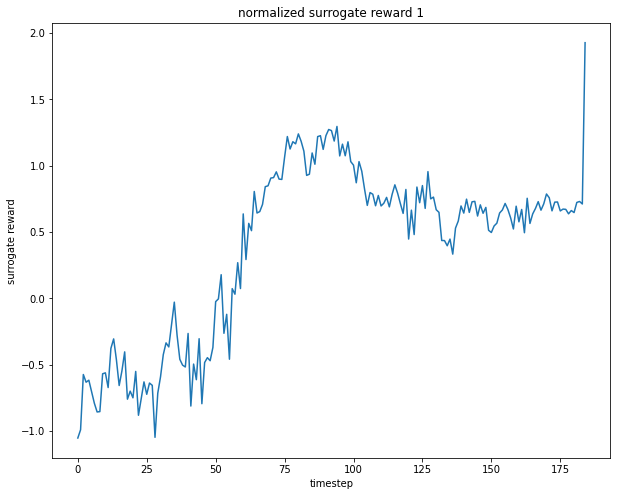

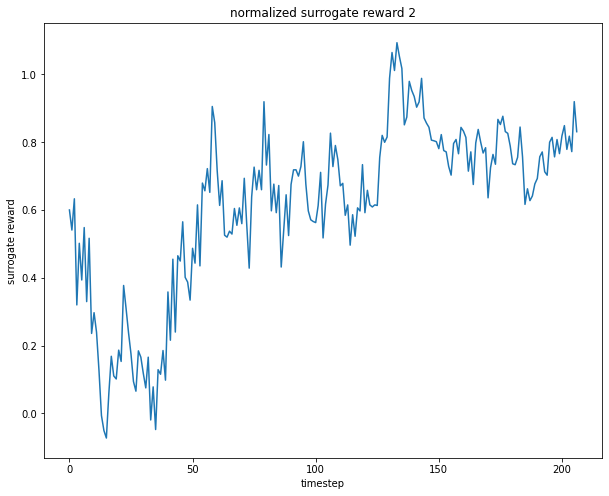

In [10]:
rew = np.concatenate((rew1, rew2))
rew_mean = rew.mean()
rew_std = rew.std()

rew1_norm = ((rew1 - rew_mean)/rew_std + 1) / 2
rew2_norm = ((rew2 - rew_mean)/rew_std + 1) / 2

plt.figure(figsize=(10, 8))
plt.plot(rew1_norm)
plt.xlabel('timestep')
plt.ylabel('surrogate reward')
plt.title(f'normalized surrogate reward 1')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(rew2_norm)
plt.xlabel('timestep')
plt.ylabel('surrogate reward')
plt.title(f'normalized surrogate reward 2')
plt.show()

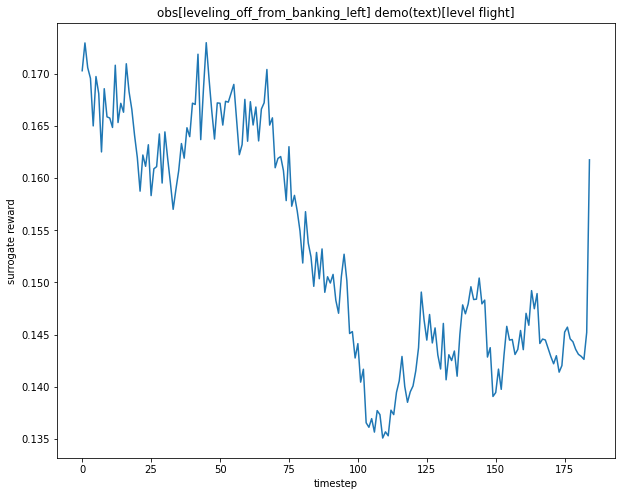

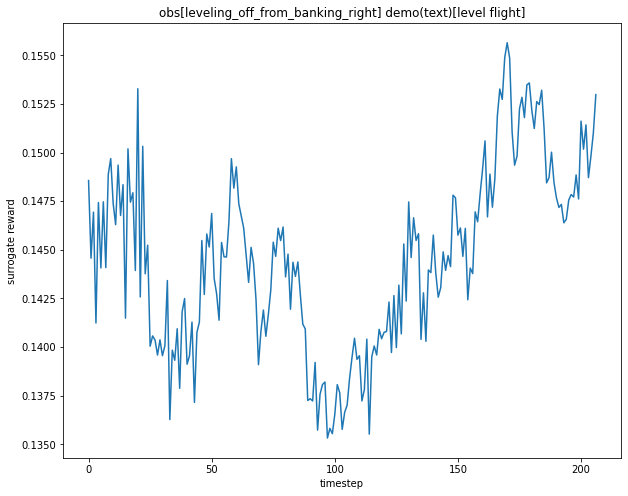

In [11]:
def plot_v2t_windowed_similarity(demo_text, obs_path):
    obs_name = obs_path.stem
    
    obs = video_to_tensor(obs_path)

    window_size = 32

    surrogate_reward = []

    with torch.no_grad():
        demo_emb = s3d_model.text_module([demo_text])["text_embedding"].to('cpu')  # [1, 512]

        for start_idx in range(obs.shape[2]-window_size+1):
            window = obs[:, :, start_idx:start_idx+window_size, :, :].to('cuda')
            window_emb = s3d_model(window)["video_embedding"].to('cpu')  # [1, 512]
            
            surrogate_reward.append(F.cosine_similarity(demo_emb, window_emb, dim=-1).item())

    plt.figure(figsize=(10, 8))
    plt.plot(surrogate_reward)
    plt.xlabel('timestep')
    plt.ylabel('surrogate reward')
    plt.title(f'obs[{obs_name}] demo(text)[{demo_text}]')
    plt.show()

plot_v2t_windowed_similarity(demo_text="level flight", obs_path=video_dir/"leveling_off_from_banking_left.mp4")
plot_v2t_windowed_similarity(demo_text="level flight", obs_path=video_dir/"leveling_off_from_banking_right.mp4")